In [1]:
from birdclef.utils import get_spark
import pyspark.sql.functions as f

In [2]:
spark = get_spark()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/24 16:26:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.parquet(
    "../../data/processed/birdclef-2023/train_embeddings_consolidated_v2_sample"
)
df.show(n=5)

+-------+----------+----------+--------------------+--------------------+--------------------+----------+
|species|track_stem|track_type|          track_name|           embedding|         predictions|start_time|
+-------+----------+----------+--------------------+--------------------+--------------------+----------+
|abhori1|  XC737347|   source2|abhori1/XC737347_...|[-9.7301635742187...|[{0, 1815, Milvag...|       195|
|abhori1|  XC513159|   source0|abhori1/XC513159_...|[-13.383581161499...|[{0, 1847, Moloth...|        54|
|abhori1|  XC513159|   source1|abhori1/XC513159_...|[-5.6110315322875...|[{0, 2975, Syrigm...|       111|
|abhori1|  XC611614|   source0|abhori1/XC611614_...|[-8.1713380813598...|[{0, 1565, Lanius...|        78|
|abhori1|  XC513159|   source0|abhori1/XC513159_...|[-15.172685623168...|[{0, 2156, Passer...|        69|
+-------+----------+----------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



Extract embeddings from source track only

In [31]:
source = df.filter(df["track_type"] == "")
source.show()


+-------+----------+----------+--------------------+--------------------+--------------------+----------+
|species|track_stem|track_type|          track_name|           embedding|         predictions|start_time|
+-------+----------+----------+--------------------+--------------------+--------------------+----------+
|abhori1|  XC641917|          |abhori1/XC641917.mp3|[-11.481126785278...|[{0, 2205, Periso...|        72|
|abhori1|  XC611614|          |abhori1/XC611614.mp3|[-15.695769309997...|[{0, 2076, Oriolu...|         3|
|abhori1|  XC398787|          |abhori1/XC398787.mp3|[-13.638436317443...|[{0, 2076, Oriolu...|        39|
|abhori1|  XC737347|          |abhori1/XC737347.mp3|[-19.533819198608...|[{0, 2076, Oriolu...|        84|
|abhori1|  XC737347|          |abhori1/XC737347.mp3|[-19.749326705932...|[{0, 2076, Oriolu...|       189|
|abhori1|  XC398787|          |abhori1/XC398787.mp3|[-11.859894752502...|[{0, 2076, Oriolu...|         0|
|abhori1|  XC737347|          |abhori1/XC73734

Exploded predictions

In [32]:
print(source.select(source.track_name).take(1)[0])

source.select(source.predictions).take(1)[0]["predictions"]

Row(track_name='abhori1/XC641917.mp3')


[Row(rank=0, index=2205, label='Perisoreus infaustus_Siberian Jay', mapped_label='sibjay1', probability=0.003058952046558261),
 Row(rank=1, index=2076, label='Oriolus larvatus_African Black-headed Oriole', mapped_label='abhori1', probability=0.0022603634279221296),
 Row(rank=2, index=3012, label='Telophorus zeylonus_Bokmakierie', mapped_label='bokmak1', probability=0.0014614507090300322),
 Row(rank=3, index=2077, label='Oriolus oriolus_Eurasian Golden Oriole', mapped_label='eugori2', probability=0.0011656048009172082),
 Row(rank=4, index=2079, label='Oriolus traillii_Maroon Oriole', mapped_label='marori2', probability=0.000852204451803118),
 Row(rank=5, index=2081, label='Oriolus xanthornus_Black-hooded Oriole', mapped_label='blhori1', probability=0.0008248982485383749),
 Row(rank=6, index=2073, label='Oriolus chinensis_Black-naped Oriole', mapped_label='blnori1', probability=0.0003854174865409732),
 Row(rank=7, index=2072, label='Oriolus brachyrynchus_Western Black-headed Oriole', map

In [35]:
explode_preds = source.select("species", "track_stem", "track_name", "embedding", "start_time", f.explode(source.predictions))
explode_preds = explode_preds.select("species", "track_stem", "track_name", "embedding", "start_time", 
                                     explode_preds.col["label"].alias("label"),
                                     explode_preds.col["mapped_label"].alias("mapped_label"),
                                     explode_preds.col["probability"].alias("probability"))
explode_preds.show()

# temp = source.select(source.track_name, f.explode(source.predictions))
# temp = temp.select(temp.track_name, temp.col["label"].alias("label"), temp.col["mapped_label"].alias("mapped_label"), 
#                    temp.col["probability"].alias("probability"))
# temp.show()
# source.show()


+-------+----------+--------------------+--------------------+----------+--------------------+------------+--------------------+
|species|track_stem|          track_name|           embedding|start_time|               label|mapped_label|         probability|
+-------+----------+--------------------+--------------------+----------+--------------------+------------+--------------------+
|abhori1|  XC641917|abhori1/XC641917.mp3|[-11.481126785278...|        72|Perisoreus infaus...|     sibjay1|0.003058952046558261|
|abhori1|  XC641917|abhori1/XC641917.mp3|[-11.481126785278...|        72|Oriolus larvatus_...|     abhori1|0.002260363427922...|
|abhori1|  XC641917|abhori1/XC641917.mp3|[-11.481126785278...|        72|Telophorus zeylon...|     bokmak1|0.001461450709030...|
|abhori1|  XC641917|abhori1/XC641917.mp3|[-11.481126785278...|        72|Oriolus oriolus_E...|     eugori2|0.001165604800917...|
|abhori1|  XC641917|abhori1/XC641917.mp3|[-11.481126785278...|        72|Oriolus traillii_...|   

Sigmoid

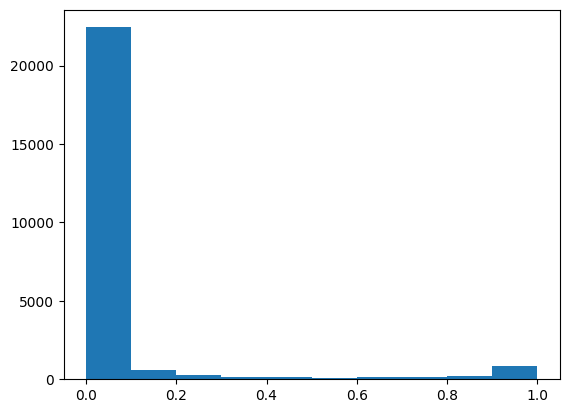

[0.5000000386951449, 0.5000000389601951, 0.5000000429930651, 0.5000000433038245, 0.5000000484203433, 0.5000000551829658, 0.5000000637714663, 0.5000000725659746, 0.5000000771316948, 0.5000000784974077, 0.5000000859485283, 0.5000000883185578, 0.5000000903397108, 0.5000001112675534, 0.5000001126591513, 0.5000001166566577, 0.500000128768562, 0.5000001402905525, 0.500000143718708, 0.5000001497755306, 0.5000001505069207, 0.5000001576640187, 0.5000001611496003, 0.5000001677787083, 0.5000001705866879, 0.5000001707746833, 0.5000001840082291, 0.5000001902988203, 0.5000002111093806, 0.500000211271086, 0.5000002175835618, 0.500000221161585, 0.5000002306457105, 0.500000235437625, 0.5000002363498481, 0.500000241217947, 0.5000002452342187, 0.5000002478751924, 0.5000002536326349, 0.5000002578927365, 0.5000002590458621, 0.50000026264334, 0.5000002649836688, 0.5000002666629086, 0.5000002792841656, 0.5000002810015189, 0.5000002812090258, 0.5000002839404658, 0.5000002859753749, 0.5000002862848021, 0.50000

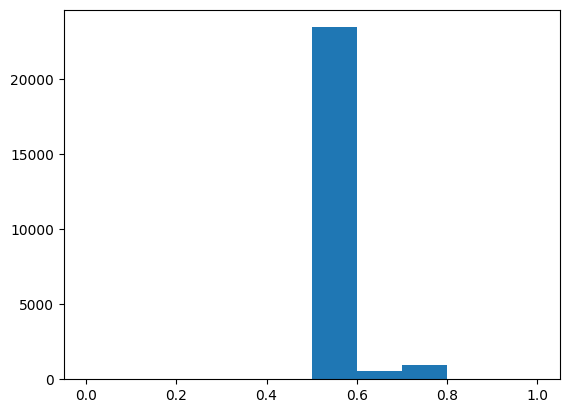

In [40]:
import matplotlib.pyplot as plt

explode_preds_sig = explode_preds.select("species", "track_stem", "track_name", "embedding", "start_time", "label", "mapped_label",
                     (1 / (1 + f.exp(-1 * explode_preds.probability))).alias("probability"))
probs_no_sig = [x["probability"] for x in explode_preds.select("probability").collect()]
plt.hist(probs_no_sig)
plt.show()
probs = [x["probability"] for x in explode_preds_sig.select("probability").collect()]
x_axis = [i / 10 for i in range(10)]
print(sorted(set(probs)))
plt.hist(probs, range = [0, 1])
plt.show()

Taking species with prob > 0.5

In [42]:
explode_preds_bird_calls = explode_preds.filter(explode_preds["probability"] >= 0.5)
explode_preds_bird_calls.show()
print(explode_preds_bird_calls.count())

+-------+----------+--------------------+--------------------+----------+--------------------+------------+------------------+
|species|track_stem|          track_name|           embedding|start_time|               label|mapped_label|       probability|
+-------+----------+--------------------+--------------------+----------+--------------------+------------+------------------+
|abhori1|  XC611614|abhori1/XC611614.mp3|[-15.695769309997...|         3|Oriolus larvatus_...|     abhori1|0.9318422675132751|
|abhori1|  XC737347|abhori1/XC737347.mp3|[-19.533819198608...|        84|Oriolus larvatus_...|     abhori1|0.5274410843849182|
|abhori1|  XC737347|abhori1/XC737347.mp3|[-19.749326705932...|       189|Oriolus larvatus_...|     abhori1|0.8413838744163513|
|abhori1|  XC737347|abhori1/XC737347.mp3|[-21.518583297729...|        75|Oriolus larvatus_...|     abhori1|0.7677854895591736|
|abhori1|  XC611614|abhori1/XC611614.mp3|[-15.915067672729...|        30|Oriolus larvatus_...|     abhori1|0.99

parsing species name

In [48]:
species = [s["species"] for s in source.select("species").collect()]
print(set(species))
print(len(species))

{'abethr1', 'abythr1', 'abhori1'}
2498


final dataset

In [81]:
data = explode_preds_bird_calls.select(["species", "probability"] + [explode_preds_bird_calls.embedding[i] for i in range(3337)])
data = data.toPandas()
data.head()

,species,probability,embedding[0],embedding[1],embedding[2],embedding[3],embedding[4],embedding[5],embedding[6],embedding[7],...,embedding[3327],embedding[3328],embedding[3329],embedding[3330],embedding[3331],embedding[3332],embedding[3333],embedding[3334],embedding[3335],embedding[3336]
0,abhori1,0.931842,-15.695769,-14.175133,-14.107721,-15.785131,-15.412916,-14.258154,-16.648735,-17.852036,...,-13.420475,-14.661019,-12.913609,-12.781441,-11.813440,-16.250906,-12.645384,-13.045488,-12.198296,-15.637187
1,abhori1,0.527441,-19.533819,-16.186634,-12.176779,-11.817211,-15.650982,-14.040951,-14.823906,-16.595118,...,-12.638477,-15.555634,-15.871542,-12.380343,-9.460049,-14.972944,-14.483743,-9.331749,-12.910712,-11.881019
2,abhori1,0.841384,-19.749327,-15.550808,-11.639582,-12.933417,-18.489109,-17.498230,-17.191210,-17.753681,...,-14.857538,-16.427847,-15.909166,-11.827403,-13.136386,-17.146564,-15.114254,-10.958441,-14.703631,-13.515043
3,abhori1,0.767785,-21.518583,-18.931110,-13.217918,-11.979479,-14.901256,-15.360685,-17.736120,-15.968261,...,-14.281636,-15.552175,-16.286346,-12.225875,-13.201905,-16.558741,-14.998167,-12.965591,-14.886533,-13.775451
4,abhori1,0.992275,-15.915068,-13.532173,-13.717117,-11.389903,-12.852736,-11.249538,-14.087188,-13.257503,...,-13.322052,-12.597613,-10.335143,-13.245964,-11.704409,-15.318541,-14.019773,-10.212161,-11.268396,-11.581400


classifier?

In [86]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(data.loc[:, data.columns != "species"], data["species"], test_size=0.25)

In [83]:
from sklearn.tree import DecisionTreeClassifier

treeClassifier = DecisionTreeClassifier()
treeClassifier.fit(train_x, train_y)

print(treeClassifier.score(test_x, test_y))


0.9857954545454546


In [84]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_x, train_y)
print(knn.score(test_x, test_y))

0.9857954545454546
